In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import csv
import numpy as np

# Read runtimes from logfiles

In [3]:
def read_logfile(logfile):
    runtimes_dict = []
    header = None
    with open(logfile, 'r') as f:
        for line in csv.reader(f, delimiter='\t'):
            if header is None:
                header = line
            else:
                runtime_dict = {}
                for (header_elem, line_elem) in zip(header, line):
                    if header_elem != 'scenario':
                        if line_elem == '':
                            runtime_dict[header_elem] = None
                        else:
                            runtime_dict[header_elem] = float(line_elem)
                    else:
                        runtime_dict[header_elem] = line_elem
                runtimes_dict.append(runtime_dict)
    return runtimes_dict

In [4]:
runtimes_dict = read_logfile("inference_runtimes.tsv")

# Plot runtimes versus idealized runtimes for various models

In [5]:
def plot_runtime_versus_idealized_runtime(runtimes_dict, label,
                                          filter_fn=None):
    print(label)
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for runtime_dict in runtimes_dict:
        if filter_fn is None or filter_fn(runtime_dict):
            ax.scatter(runtime_dict["inference_runtime"],
                       runtime_dict["inference_idealized_runtime"],
                       marker='o', color='black')
    ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')

    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Runtime (seconds)")
    ax.set_ylabel("Idealized runtime\n(seconds)")
    sns.despine()
    plt.show()

All


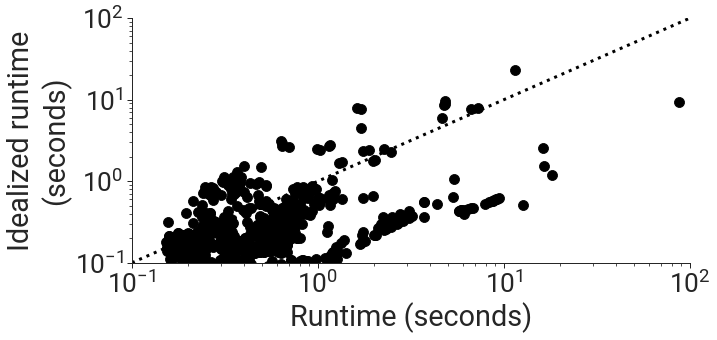

In [6]:
plot_runtime_versus_idealized_runtime(runtimes_dict, "All")

OpenAI/davinci


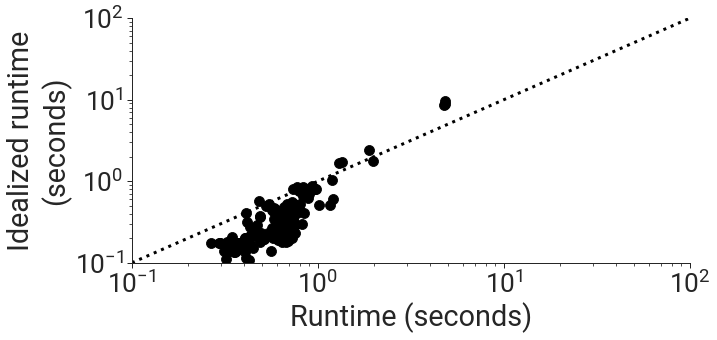

OpenAI/curie


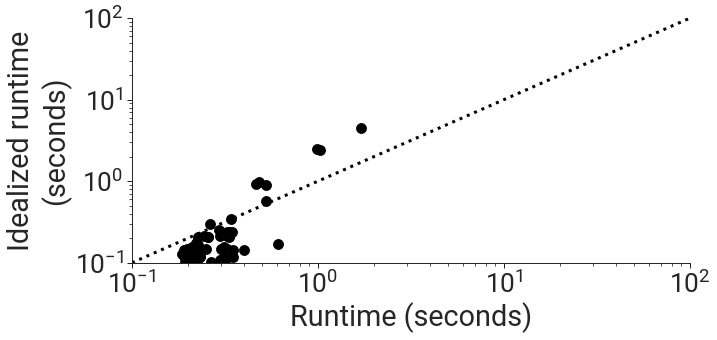

OpenAI/text-davinci-001


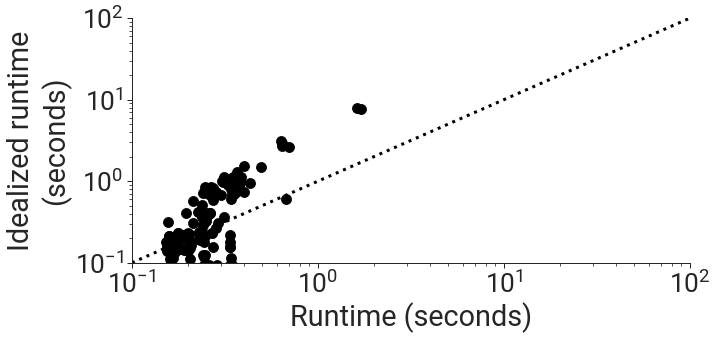

AI21/j1-jumbo


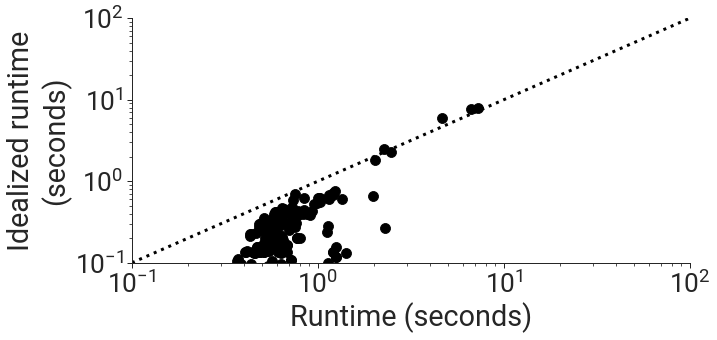

Anthropic


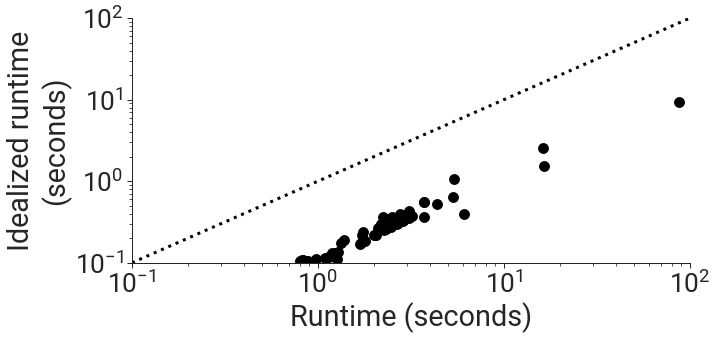

MT-Turing-NLG


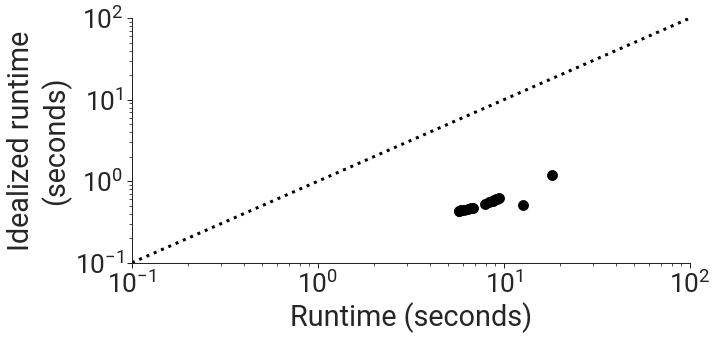

In [7]:
def filter_fn(runtime_dict, model):
    scenario = runtime_dict["scenario"]
    if model in scenario:
        return True
    return False

plot_runtime_versus_idealized_runtime(runtimes_dict, "OpenAI/davinci",
                                      lambda x: filter_fn(x, "openai_davinci"))
plot_runtime_versus_idealized_runtime(runtimes_dict, "OpenAI/curie",
                                      lambda x: filter_fn(x, "openai_curie"))
plot_runtime_versus_idealized_runtime(runtimes_dict, "OpenAI/text-davinci-001",
                                      lambda x: filter_fn(x, "openai_text-davinci-001"))
plot_runtime_versus_idealized_runtime(runtimes_dict, "AI21/j1-jumbo",
                                      lambda x: filter_fn(x, "ai21_j1-jumbo"))
plot_runtime_versus_idealized_runtime(runtimes_dict, "Anthropic",
                                      lambda x: filter_fn(x, "anthropic_stanford-online-helpful-v4-s3"))
plot_runtime_versus_idealized_runtime(runtimes_dict, "MT-Turing-NLG",
                                      lambda x: filter_fn(x, "microsoft_TNLGv2_530B"))

# Compare runtimes for various models

In [8]:
def plot_runtime_for_various_models(runtimes_dict, model1, model2,
                                    model1_label, model2_label):
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    runtimes_per_scenario = {}
    for runtime_dict in runtimes_dict:
        scenario = runtime_dict["scenario"]
        for i, model in enumerate([model1, model2]):
            if model in scenario:
                scenario = scenario.split(",")
                scenario.remove("model=%s" % model)
                scenario = ",".join(scenario)
                if scenario not in runtimes_per_scenario:
                    runtimes_per_scenario[scenario] = {}
                runtimes_per_scenario[scenario][f"model{i}"] = runtime_dict["inference_runtime"]

    ratios = []
    for scenario in runtimes_per_scenario:
        ax.scatter(runtimes_per_scenario[scenario]["model0"],
                   runtimes_per_scenario[scenario]["model1"],
                   marker='o', color='black')
        if runtimes_per_scenario[scenario]["model0"] is None or \
            runtimes_per_scenario[scenario]["model1"] is None:
            continue
        ratios.append(runtimes_per_scenario[scenario]["model0"] /
                      runtimes_per_scenario[scenario]["model1"])
    print(f"Average runtime ratio: {np.mean(ratios):.2f}")
    print(f"Maximum runtime ratio: {np.max(ratios):.2f}")
    print(f"Minimum runtime ratio: {np.min(ratios):.2f}")
    ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')

    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f"{model1_label} runtime (seconds)")
    ax.set_ylabel(f"{model2_label}\nruntime (seconds)")
    sns.despine()
    plt.show()

Average runtime ratio: 2.41
Maximum runtime ratio: 7.66
Minimum runtime ratio: 1.57


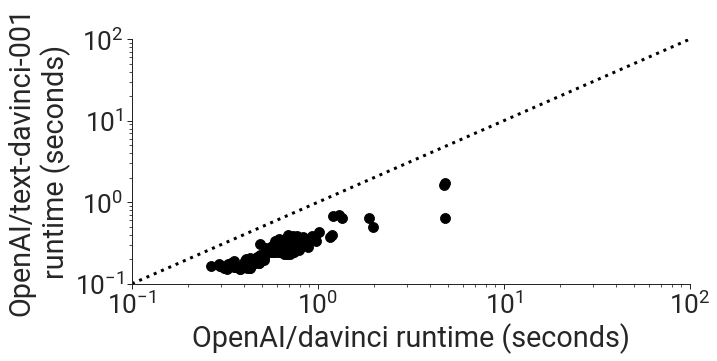

In [10]:
plot_runtime_for_various_models(runtimes_dict, "openai_davinci", "openai_text-davinci-001",
                               "OpenAI/davinci", "OpenAI/text-davinci-001")